### Interactive notebook to demo the interactive PPCA model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import math
import torch
import numpy as np
# from scipy.stats import invgamma, lognorm
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
import seaborn as sns

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

from IPython.display import display, clear_output
from ipywidgets import Output, VBox, HBox, Layout
from ipywidgets import Label, Button, FloatSlider, RadioButtons, Dropdown
from ipywidgets import interact

from bqplot import (
    Axis, ColorAxis, LinearScale, LogScale, DateColorScale, OrdinalScale,
    OrdinalColorScale, ColorScale, Scatter, Lines, Figure, Tooltip
)

from ppca_model import MAP, generate
from common.dataset import dataset
import common.plot.simple_plot
from common.plot.simple_plot import SimpleFigure
from common.plot.scatter import imscatter, ellipse_scatter
from common.metric.dr_metrics import DRMetric

from sklearn.cluster import KMeans

dataset.set_data_home('./data')

In [2]:
dataset_name = 'FASHION200'
is_img_dataset = dataset_name.lower().startswith( ('font', 'quickdraw', 'fashion', 'digit', 'mnist') )

# X, y, labels = dataset.load_country(2014)
# X_original = X
X_original, X, y = dataset.load_dataset(dataset_name, preprocessing_method='standardize')

learning_rate = 0.2
n_iters = 250
k_components = 4

# # try to remove the 'bad' class
# bad_class = 9
# mask = ~(y==bad_class)

# X_original = X_original[mask]
# X = X[mask]
# y = y[mask]

In [3]:
# global interactive data, let's call it 'state'

def set_initial_state():
    global state
    state = {
        'moved_points': {}, # reset moved points
        'debug_msg': 'Init state',
        'losses': losses,

        'z2d_loc': z2d_loc,
        'z2d_scale': z2d_scale,
        'errors': errors,

        'z2d_loc_old': None,
        'z2d_scale_old': None,
        'errors_old': None,

        'avg_err': avg_err,
        'min_err': min_err,
        'max_err': max_err,
        'auc_rnx': auc_rnx,

        'kmeans': kmeans,
        'k_components': k_components,
        'cluster_err': cluster_err,
        'pred_labels': pred_labels,

        'looking_id': -1, # id of point under mouse cursor
        'filter_mode': 'upper', # filter errors values
    }

In [4]:
# run model the first time to have an init embdedding
losses, z2d_loc, z2d_scale, _, _ = MAP(X, learning_rate, n_iters)

errors = np.linalg.norm(z2d_scale, axis=1)
avg_err, min_err, max_err  = errors.mean(), errors.min(), errors.max()
auc_rnx = DRMetric(X, z2d_loc).auc_rnx()


def calcuate_cluster_err(K, z2d):
    kmeans = KMeans(n_clusters=K, random_state=2019)
    pred_labels = kmeans.fit_predict(z2d)
    cluster_err = kmeans.inertia_
    return kmeans, pred_labels, cluster_err

kmeans, pred_labels, cluster_err = calcuate_cluster_err(K=k_components, z2d=z2d_loc)

print(f"""
    avg_err: {avg_err}
    min_err: {min_err}
    max_err: {max_err}
    auc_rnx: {auc_rnx}
    cluster_err: {cluster_err}
""")

set_initial_state()

100%|██████████| 250/250 [00:02<00:00, 104.60it/s]


    avg_err: 0.14323802292346954
    min_err: 0.10425673425197601
    max_err: 0.3445318043231964
    auc_rnx: 0.3554561403832155
    cluster_err: 244.0906092075311



In [5]:
def show_top_error_class():
    from collections import Counter
    errors = np.linalg.norm(state['z2d_scale'], axis=1)

    K = int(X.shape[0] * 0.1)
    labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
                  4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
                  7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

    top_K_ind = np.argpartition(errors, -K)[-K:]
    class_top_K = y[top_K_ind]
    cnt = Counter(class_top_K)
    count_top_K = []
    lbl_names = []
    for i in labels_map:
        count_top_K.append(cnt[i])
        lbl_names.append(f"{labels_map[i]} [{i}]")

    ind = list(labels_map.keys())
    plt.barh(ind, count_top_K)
    plt.yticks(ind, lbl_names)
    plt.show()

In [6]:
def _plot_segmented_lines(ax, from_pos, to_pos):
    lc = mc.LineCollection(list(zip(from_pos, to_pos)), color='black',
                           linestyle='--', linewidths=0.3, alpha=0.7)
    ax.add_collection(lc)
    
def _scatter_with_images(ax, original_data, z2d):
    ax.scatter(z2d[:, 0], z2d[:, 1])
    if is_img_dataset:
        imscatter(ax, z2d, data=original_data, zoom=.6, inverse_cmap=True, frameon=False)
        
def scatter_with_images_compare(ax, original_data, new2d, old2d=None, moved_points=[]):
    ax.axis('off')
    _scatter_with_images(ax, original_data, new2d)
    if old2d is not None:
        _plot_segmented_lines(ax=ax, from_pos=old2d, to_pos=new2d)

    # border around moved points
    if len(moved_points) > 0 and old2d is not None:
        old_pos = old2d[moved_points]
        ax.scatter(old_pos[:, 0], old_pos[:, 1], zorder=0,
                    s=80, alpha=0.75, linewidths=2.0, edgecolor='red', facecolor='white')
        
        new_pos = new2d[moved_points]
        ax.scatter(new_pos[:, 0], new_pos[:, 1], zorder=0,
                    s=700, alpha=1.0, linewidths=2.0, edgecolor='orange', facecolor='white')

In [7]:
def show_kmeans_pred(ax, kmeans, z2d):
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].
    # Plot the decision boundary. For that, we will assign a color to each
    expand = 1.2
    x_min, x_max = z2d[:, 0].min()*expand, z2d[:, 0].max()*expand
    y_min, y_max = z2d[:, 1].min()*expand, z2d[:, 1].max()*expand
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap='tab20c_r', alpha=0.25) # plt.cm.RdYlBu
    #     ax.imshow(Z, interpolation='nearest',
    #                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    #                cmap=plt.cm.Pastel1, alpha=0.15,
    #                aspect='auto', origin='lower')

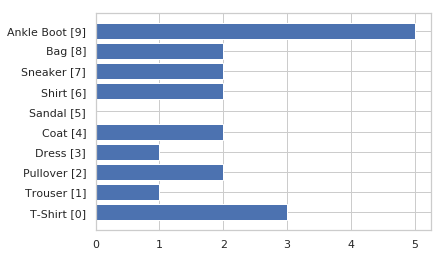

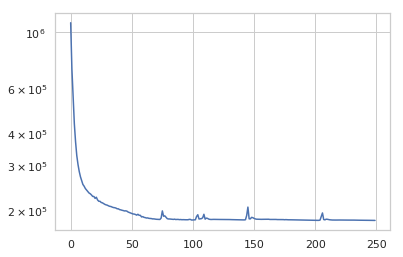

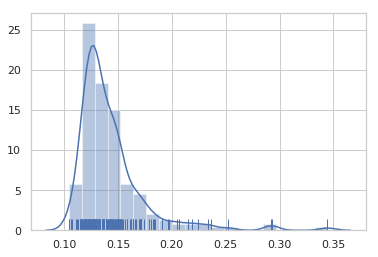

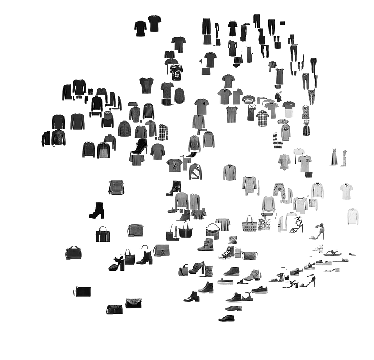

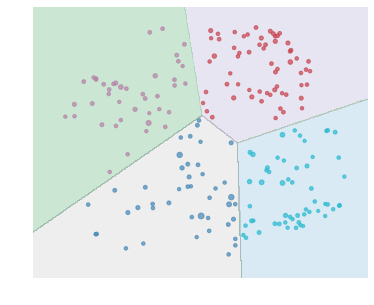

In [8]:
show_top_error_class()
plt.show()

plt.semilogy(losses)
plt.show()

sns.distplot(errors, bins=20, kde=True, rug=True)
plt.show()

_, ax0 = plt.subplots(1,1, figsize=(6,6))
scatter_with_images_compare(ax0, X_original, z2d_loc)

_, ax1 = plt.subplots(1,1, figsize=(6,5))
ax1.axis('off')
ax1.scatter(z2d_loc[:,0], z2d_loc[:,1], c=pred_labels, s=100*errors, alpha=0.7, cmap='tab10')
show_kmeans_pred(ax1, kmeans, z2d_loc)

In [9]:
# create base interactive scatter bqplot
sc_x = LinearScale()
sc_y = LinearScale()
sc_c = OrdinalColorScale(colors=[u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf'])
sc_size = LinearScale(min=0.0, max=0.6) # if not set, it will take range from data

def_tt = (Tooltip(fields=['index', 'size'], formats=['', '.3f']) if is_img_dataset
          else Tooltip(fields=['index', 'name']))


scatt = Scatter(
    x=[], #z2d_loc[:, 0],
    y=[], #z2d_loc[:, 1],
    color=[],
    size=[], #errors,
    default_size=300, # max size of point
    # names=np.arange(z2d_loc.shape[0]),
    # display_names=False,
    default_opacities=[0.4],
    scales={'x': sc_x, 'y': sc_y, 'color': sc_c, 'size': sc_size},
    enable_move=True,
    tooltip=def_tt,
    unhovered_style={'opacity': 0.3},
    selected=[], # top_K_ind.tolist(),
    selected_style={'stroke': 'red','stroke-width':2, 'opacity':1.0},
)

if not is_img_dataset:
    scatt.names = labels
    scatt.display_names = False


def reset_scatt():
    scatt.x = []
    scatt.y = []
    scatt.color=[]
    scatt.size=[]

ax_x = Axis(scale=sc_x, grid_color='#EAECEE', grid_lines='dashed')
ax_y = Axis(scale=sc_y, orientation='vertical', grid_color='#EAECEE', grid_lines='dashed')
ax_c = ColorAxis(scale=sc_c, orientation='vertical', side='right')

fig = Figure(marks=[scatt], axes=[ax_x, ax_y], title='',
             fig_margin=dict(top=20, bottom=20, left=20, right=20))
fig.background_style = {'fill': 'White'}
fig.layout = {'width': '580px', 'height': '480px'}

In [10]:
# debug label to show some text
lbl = Label(color='green', font_size='18px', value=state['debug_msg'])

def drag_handler(scatter, value):
    p = value['point']
    point_id = int(value['index'])
    state['moved_points'][point_id] = [float(p['x']), float(p['y'])] # TODO add sigma_fix value
    lbl.value = f"{len( state['moved_points'] )} manually selected"

def mouse_hover(scatter, value):
    state['looking_id'] = int(value['data']['index'])
    if is_img_dataset:
        update_hover_image()
    
scatt.on_drag_end(drag_handler)
scatt.on_hover(mouse_hover)

In [11]:
# output widget to hold the static matplotlib plot
layout_for_out_widget = {'border': '0px solid black', 'width': '700px', 'height':'150px', 'display': 'inline-block'}
out = Output(layout={**layout_for_out_widget, **{'height': '100%'}})
hover_img_out = Output(layout={**layout_for_out_widget, **{'width': '150px'}})
hist_out = Output(layout={**layout_for_out_widget, **{'width': '550px'}})

# static matplotlib scatter plot with images
_, ax = plt.subplots(1, 1, figsize=(9,9))
plt.close()

_, ax_hover = plt.subplots(1, 1, figsize=(2,2))
plt.close()

_, ax_hist = plt.subplots(1, 1, figsize=(7,2))
plt.close()

In [12]:
# define steps to run model and update graphs in an interactive manner
# all the data are shared between interactive components via the global state

def run_ippca():
    moved_points = state['moved_points']
    sigma_fix = 1e-4 # can set different sigma_fix for each moved point
    
    losses, z2d_loc, z2d_scale, W, sigma = MAP(
        X, learning_rate, n_iters,
        moved_points=moved_points, sigma_fix=sigma_fix)
    
    errors = np.linalg.norm(z2d_scale, axis=1)
    avg_err, min_err, max_err = errors.mean(), errors.min(), errors.max()
    auc_rnx = DRMetric(X, z2d_loc).auc_rnx()
    kmeans, pred_labels, cluster_err = calcuate_cluster_err(K=state['k_components'], z2d=z2d_loc)

    
    # update global state, note to change each field of the global state dict
    # state['moved_points'] = {} # reset moved points
    state['debug_msg'] = 'Model updated'
    state['losses'] = losses
    
    state['z2d_loc_old'] = state['z2d_loc']
    state['z2d_scale_old'] = state['z2d_scale']
    state['errors_old'] = state['errors']
    
    state['z2d_loc'] = z2d_loc
    state['z2d_scale'] = z2d_scale
    state['errors'] = errors
    
    state['avg_err'] = avg_err
    state['min_err'] = min_err
    state['max_err'] = max_err
    
    state['auc_rnx'] = auc_rnx
    state['cluster_err'] = cluster_err
    state['pred_labels'] = pred_labels
    state['kmeans'] = kmeans
    

def make_title():
    return "avg_err={:.3f}, auc_rnx={:.3f}, cluster_err={:.3f}".format(
        state['avg_err'], state['auc_rnx'], state['cluster_err'])
    
def update_static_imscatter():
    with out:        
        ax.clear()
        plt.rcParams.update({'font.size': 32})
        scatter_with_images_compare(ax, X_original, new2d=state['z2d_loc'], old2d=state['z2d_loc_old'],
                                    moved_points=list(state['moved_points'].keys()))
        show_kmeans_pred(ax, state['kmeans'], state['z2d_loc'])
        ax.set_title(f"{state['k_components']} user-defined group in 2D")
        clear_output(wait=True)
        plt.tight_layout()
        display(ax.figure)
        plt.close()
        

def update_scatter_bqplot():
    fig.title = make_title()
    scatt.x = state['z2d_loc'][:,0]
    scatt.y = state['z2d_loc'][:,1]
    scatt.size = state['errors']
    scatt.color = state['pred_labels']
    scatt.selected = list(state['moved_points'].keys())
    
    
def update_hover_image():
    hover_id = state['looking_id']
    img = X_original[hover_id]
    img_size = int(math.sqrt(len(img)))
    with hover_img_out:
        ax_hover.clear()
        ax_hover.imshow(X_original[hover_id].reshape(img_size, img_size), cmap='gray_r')
        ax_hover.axis('off')
        clear_output(wait=True)
        display(ax_hover.figure)
        plt.close()
        
        
def update_histogram():
    with hist_out:
        ax_hist.clear()
        sns.distplot(state['errors'], ax=ax_hist, bins=20, kde=True, rug=True)
        clear_output(wait=True)
        display(ax_hist.figure)
        plt.close()    

In [13]:
def show_avg_error():
    moved_ids = list(state['moved_points'].keys())
    errors = state['errors']
    avg_rest = (errors.sum() - errors[moved_ids].sum()) / (errors.shape[0] - errors[moved_ids].shape[0])
    print(f"AVG error for ALL={errors.mean()}, for REST={avg_rest}")
    

def rerun_model(_):
    # print('before moving: '); show_avg_error(); show_top_error_class()
    run_ippca()
    # print('after moving: '); show_avg_error(); show_top_error_class()

    update_histogram()
    update_threshold_slider()
    update_static_imscatter()
    update_scatter_bqplot()

    
def rerun_kmeans(_):
    kmeans, pred_labels, cluster_err = calcuate_cluster_err(K=state['k_components'], z2d=state['z2d_loc'])
    state['cluster_err'] = cluster_err
    state['pred_labels'] = pred_labels
    state['kmeans'] = kmeans
    update_scatter_bqplot()
    update_static_imscatter()
    

def reset_gui(_):
    set_initial_state()
    reset_scatt()
    lbl.value = 'Reset!'
    
    ax.clear()
    ax_hover.clear()
    ax_hist.clear()
    out.clear_output(wait=True)
    hover_img_out.clear_output(wait=True)
    hist_out.clear_output(wait=True)
    
    select_k.value = state['k_components']
    rerun_kmeans(_)
    

def on_threshold_change(change):
    fix_threshold = change['new']
    errros = state['errors']
    (ok_idx,) = (np.where(errors >= fix_threshold) if state['filter_mode'] == 'upper'
                 else np.where(errors <= fix_threshold))
    scatt.selected = ok_idx.tolist()
    lbl.value = f"{len(ok_idx)} points affected"
    
    
def on_radio_filter_change(change):
    state['filter_mode'] = change['new']
    

def on_k_components_change(change):
    state['k_components'] = change['new']


def update_threshold_slider():
    threshold_slider.min = state['min_err']
    threshold_slider.max = state['max_err']


def set_threshold(_):
    ok_idx = scatt.selected
    if ok_idx:
        ok_points = {idx: [px, py] for idx, [px, py] in zip(ok_idx, state['z2d_loc'][ok_idx].tolist())}
        state['moved_points'] = ok_points
        lbl.value = f"{len(ok_points)} points auto selected"
        

# button to run iPPCA
btn_run = Button(description='Update Model', icon='check',  button_style='success') # 'success', 'info', 'warning', 'danger' or ''
btn_reset = Button(description='Reset', button_style='warning')
btn_rerun_kmeans = Button(description='Rerun KMeans')
btn_set_threshold = Button(description='Set Threshold')
radio_filter_mode = RadioButtons(options=['upper', 'lower'], description='Filter:')
select_k = Dropdown(options=range(2, len(np.unique(y))+1), value=state['k_components'], description='K:',
                    layout={'width':'200px', 'margin': '0px 10px 0px 0px'})
threshold_slider = FloatSlider(min=state['min_err'], max=state['max_err'], step=0.005,
                               description='Avg variance threshold: ',
                               layout=Layout(width='450px'),
                               style={'description_width': 'initial', 'align_items':'flex-end'})

btn_run.on_click(rerun_model)
btn_rerun_kmeans.on_click(rerun_kmeans)
btn_reset.on_click(reset_gui)
btn_set_threshold.on_click(set_threshold)
threshold_slider.observe(on_threshold_change, names='value')
radio_filter_mode.observe(on_radio_filter_change, names='value')
select_k.observe(on_k_components_change, names='value')

In [17]:
# feed init data to scatter bqplot and build static imscatter
reset_gui(_)
update_scatter_bqplot()
update_static_imscatter()
update_static_imscatter()
update_histogram()

# whole layout
control_buttons = VBox([btn_reset, btn_set_threshold, btn_rerun_kmeans, btn_run],
                       layout=Layout(margin='10px 0px 10px 110px'))
VBox([
    HBox([hist_out, hover_img_out, control_buttons]),
    HBox([
        VBox([threshold_slider, lbl], layout={'width': '70%'}),
        radio_filter_mode,
        HBox([select_k]),
    ]),
    HBox([out,fig]),
])

In [15]:
# idea: calculate errors diff
new_errs = state['errors']
old_errs = state['errors_old']

# keep the points that error does not increase: old - new >= 0
diff = old_errs - new_errs
(good_points,) = np.where(diff >= 0)

good_points


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
scatt.selected = good_points.tolist()

In [ ]:
def print_metric(z2d):
    print(z2d.shape)
    d1 = DRMetric(X, z2d)
    print(d1.auc_rnx(), d1.pearsonr(), d1.cca_stress(), d1.mds_isotonic(), d1.sammon_nlm())
    

print_metric(state['z2d_loc_old'])
print_metric(state['z2d_loc'])